In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import emcee

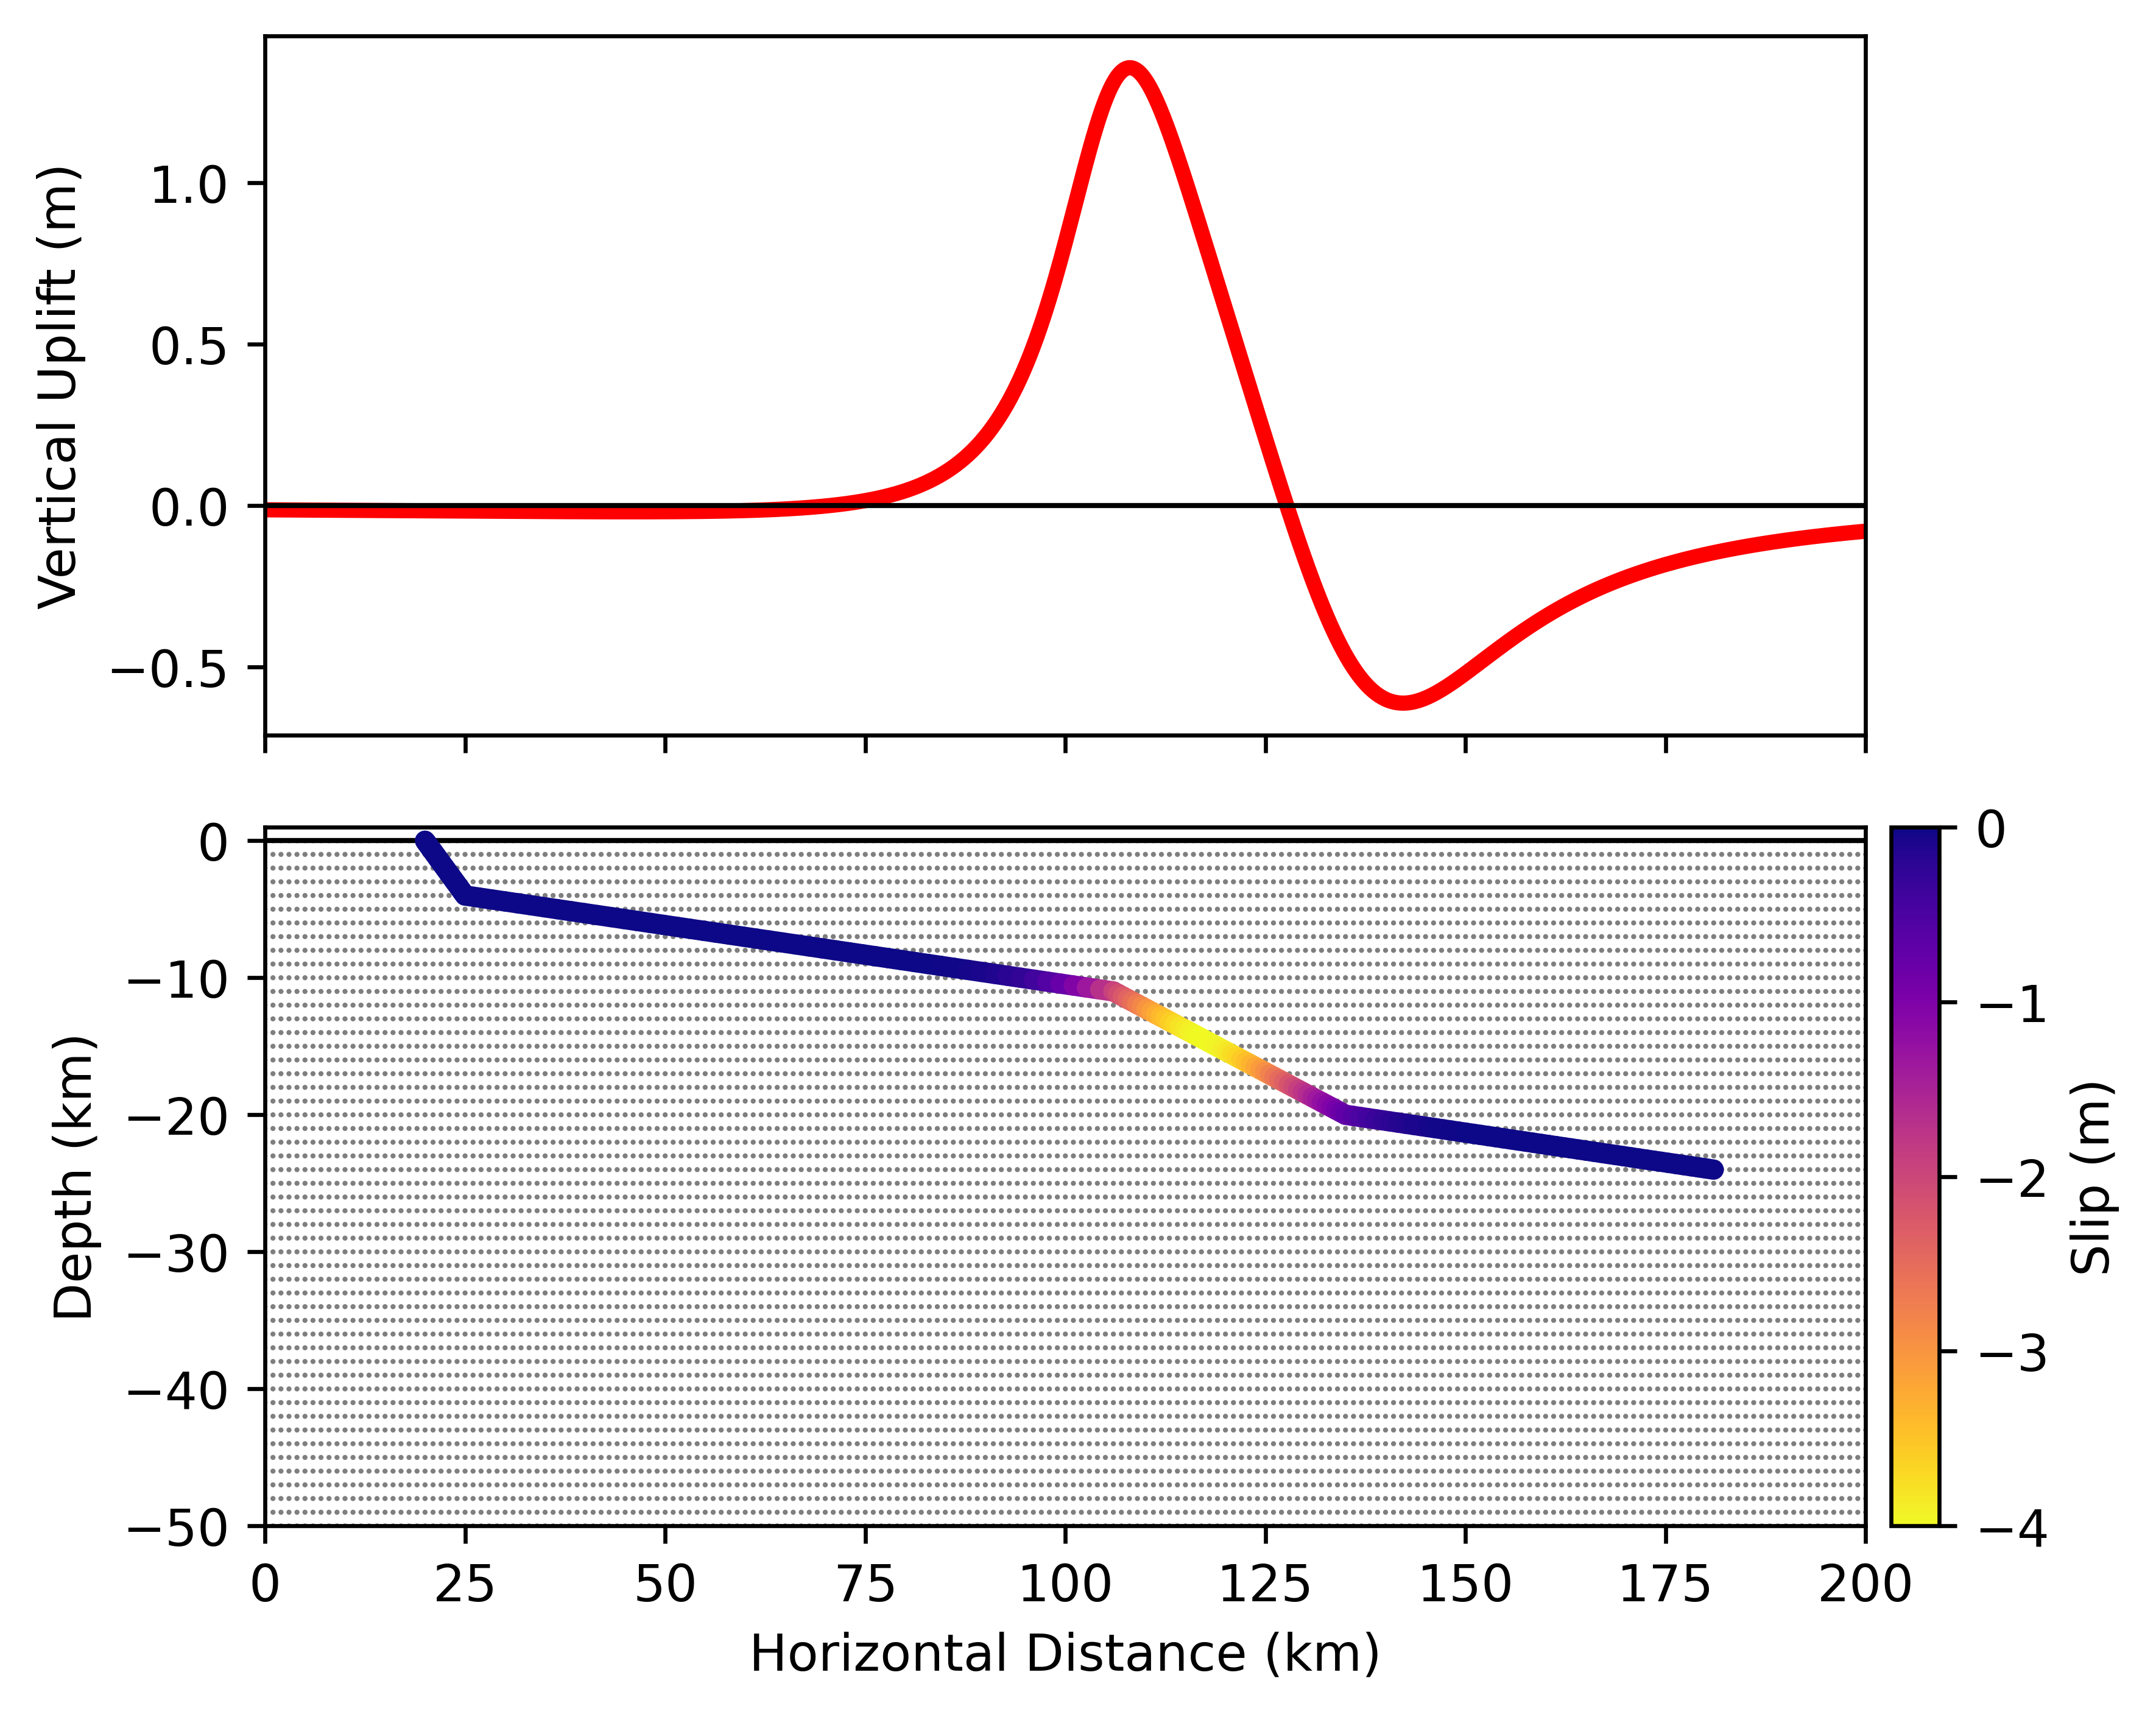

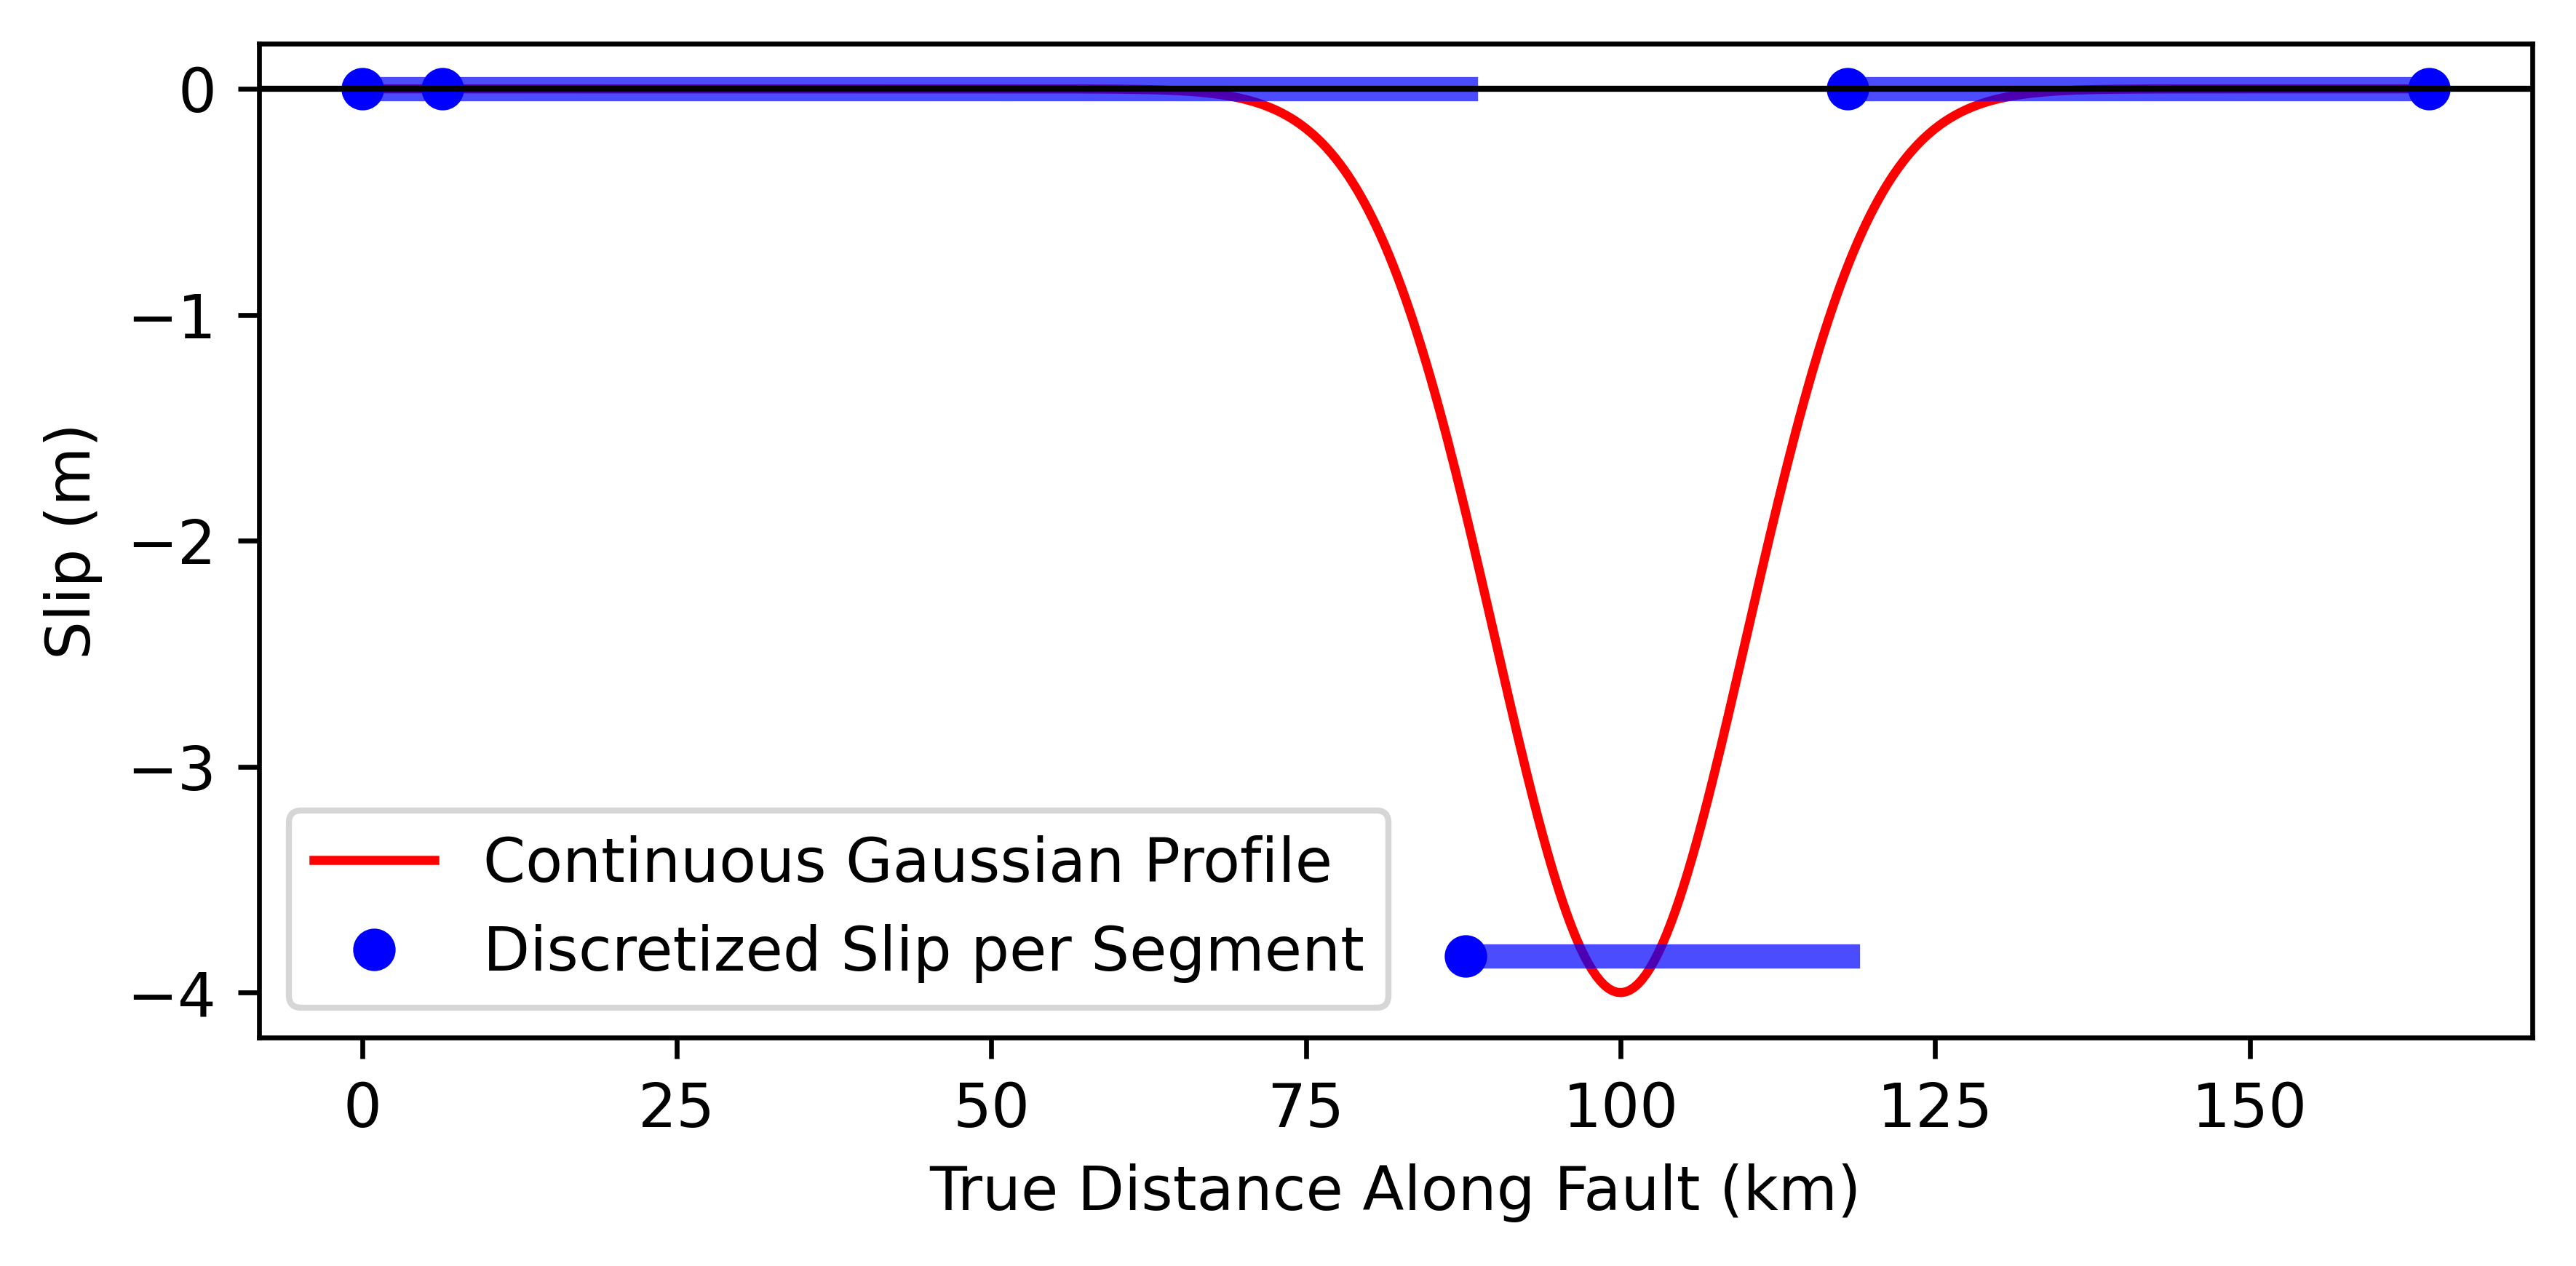

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

x_min, x_max = 0.0, 200.0
y_top, y_bot = 0.0, -50.0
dx_nodes, dy_nodes = 1.0, 1.0

x_nodes = np.arange(x_min, x_max + 0.1, dx_nodes)
y_nodes = np.arange(y_top, y_bot - 0.1, -dy_nodes)
all_nodes = np.array([(xn, yn) for xn in x_nodes for yn in y_nodes])
num_nodes = len(all_nodes)

SLIP_AMP_METERS = -4.0
SLIP_MEAN = 100.0
SLIP_STD = 10.0

true_faults_geom = [
    {'start': (20.0, 0.0),  'end': (25.0, -4.0)},
    {'start': (25.0, -4.0),  'end': (106.0, -11.0)},
    {'start': (106.0, -11.0),  'end': (135.0, -20.0)},
    {'start': (135.0, -20.0),  'end': (181.0, -24.0)},
]

segment_lengths = []
cumulative_lengths = [0.0]
for f in true_faults_geom:
    x1, z1 = f['start']
    x2, z2 = f['end']
    length = np.hypot(x2 - x1, z2 - z1)
    segment_lengths.append(length)
    cumulative_lengths.append(cumulative_lengths[-1] + length)
total_fault_length = cumulative_lengths[-1]

def gaussian_slip(x, amp, mean, std):
    return amp * np.exp(-((x - mean)**2) / (2 * std**2))

true_faults = []
for i, f_geom in enumerate(true_faults_geom):
    midpoint_length = cumulative_lengths[i] + segment_lengths[i] / 2.0
    slip = gaussian_slip(midpoint_length, SLIP_AMP_METERS, SLIP_MEAN, SLIP_STD)
    true_faults.append({**f_geom, 'slip': slip})

x_obs = np.linspace(x_min, x_max, 1001)

def calculate_uplift_from_slip(x_obs, slip, delta, d_start, x_start):
    if d_start == 0:
        arcterm = np.arctan2((x_obs - x_start), 1e-12)
        uplift = -(slip / np.pi) * (np.sin(delta) * arcterm)
    else:
        zeta = (x_obs - x_start) / d_start
        uplift = -(slip / np.pi) * (np.sin(delta) * np.arctan(zeta) +
                                 (np.cos(delta) + zeta * np.sin(delta)) / (1.0 + zeta**2))
    return uplift

uplift_total = np.zeros_like(x_obs)
for f in true_faults:
    x1, z1 = f['start']
    x2, z2 = f['end']
    slip = f['slip']
    if slip == 0:
        continue
    d_top, d_bot = -z1, -z2
    x_top, x_bot = x1, x2
    delta = np.arctan2(-(z2 - z1), x2 - x1)
    uplift_top = calculate_uplift_from_slip(x_obs, slip,  delta, d_top, x_top)
    uplift_bot = calculate_uplift_from_slip(x_obs, -slip, delta, d_bot, x_bot)
    uplift_total += (uplift_top + uplift_bot)

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(6,5), sharex=True)

ax_top.set_xlim(x_min, x_max)
ax_top.plot(x_obs, uplift_total, lw=3, color='red',label="Vertical Uplift")
ax_top.axhline(0, lw=1.0, color='black')
ax_top.set_ylabel("Vertical Uplift (m)")

divider_top = make_axes_locatable(ax_top)
cax_top = divider_top.append_axes("right", size="3%", pad=0.07)
cax_top.axis('off')

ax_bot.axhline(0, lw=1.0, color='black')

cmap = plt.cm.plasma_r
norm = Normalize(vmin=SLIP_AMP_METERS, vmax=0)

n_gradient_points = 50
for i, f_geom in enumerate(true_faults_geom):
    x1, z1 = f_geom['start']
    x2, z2 = f_geom['end']
    x_points = np.linspace(x1, x2, n_gradient_points)
    z_points = np.linspace(z1, z2, n_gradient_points)
    start_len = cumulative_lengths[i]
    end_len = cumulative_lengths[i+1]
    len_points = np.linspace(start_len, end_len, n_gradient_points)
    for j in range(n_gradient_points - 1):
        mid_len = (len_points[j] + len_points[j+1]) / 2.0
        slip_m = gaussian_slip(mid_len, SLIP_AMP_METERS, SLIP_MEAN, SLIP_STD)
        color = cmap(norm(slip_m))
        ax_bot.plot(x_points[j:j+2], z_points[j:j+2], color=color, lw=4, zorder=10, solid_capstyle='round')

Xg, Yg = np.meshgrid(x_nodes, y_nodes)
ax_bot.scatter(Xg.flatten(), Yg.flatten(), s=1, alpha=0.5, edgecolor='none', c='k', zorder=3)

divider_bot = make_axes_locatable(ax_bot)
cax_bot = divider_bot.append_axes("right", size="3%", pad=0.07)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax_bot)
cbar.set_label('Slip (m)', fontsize=10)

ax_bot.set_xlabel("Horizontal Distance (km)")
ax_bot.set_ylabel("Depth (km)")
ax_bot.set_xlim(x_min, x_max)
ax_bot.set_ylim(y_bot, 1)

plt.tight_layout(rect=[0, 0, 1, 0.96])

fig_slip, ax_slip = plt.subplots(figsize=(6,3))
length_domain = np.linspace(0, total_fault_length, 500)
slip_profile = gaussian_slip(length_domain, SLIP_AMP_METERS, SLIP_MEAN, SLIP_STD)
ax_slip.plot(length_domain, slip_profile, 'r-', label="Continuous Gaussian Profile")

for i, f in enumerate(true_faults):
    start_len = cumulative_lengths[i]
    end_len = cumulative_lengths[i+1]
    slip_m = f['slip']
    ax_slip.plot([start_len, end_len], [slip_m, slip_m], 'b-', lw=4, alpha=0.7)
    ax_slip.plot(start_len, slip_m, 'bo', markersize=6)
ax_slip.plot(end_len, slip_m, 'bo', markersize=6, label="Discretized Slip per Segment")

ax_slip.set_xlabel("True Distance Along Fault (km)")
ax_slip.set_ylabel("Slip (m)")
ax_slip.legend()
ax_slip.axhline(0, lw=1.0, color='black')

plt.tight_layout()
plt.show()


--- Running MCMC Inversion ---


100%|██████████| 5000/5000 [00:21<00:00, 229.15it/s]


--- MCMC Finished ---


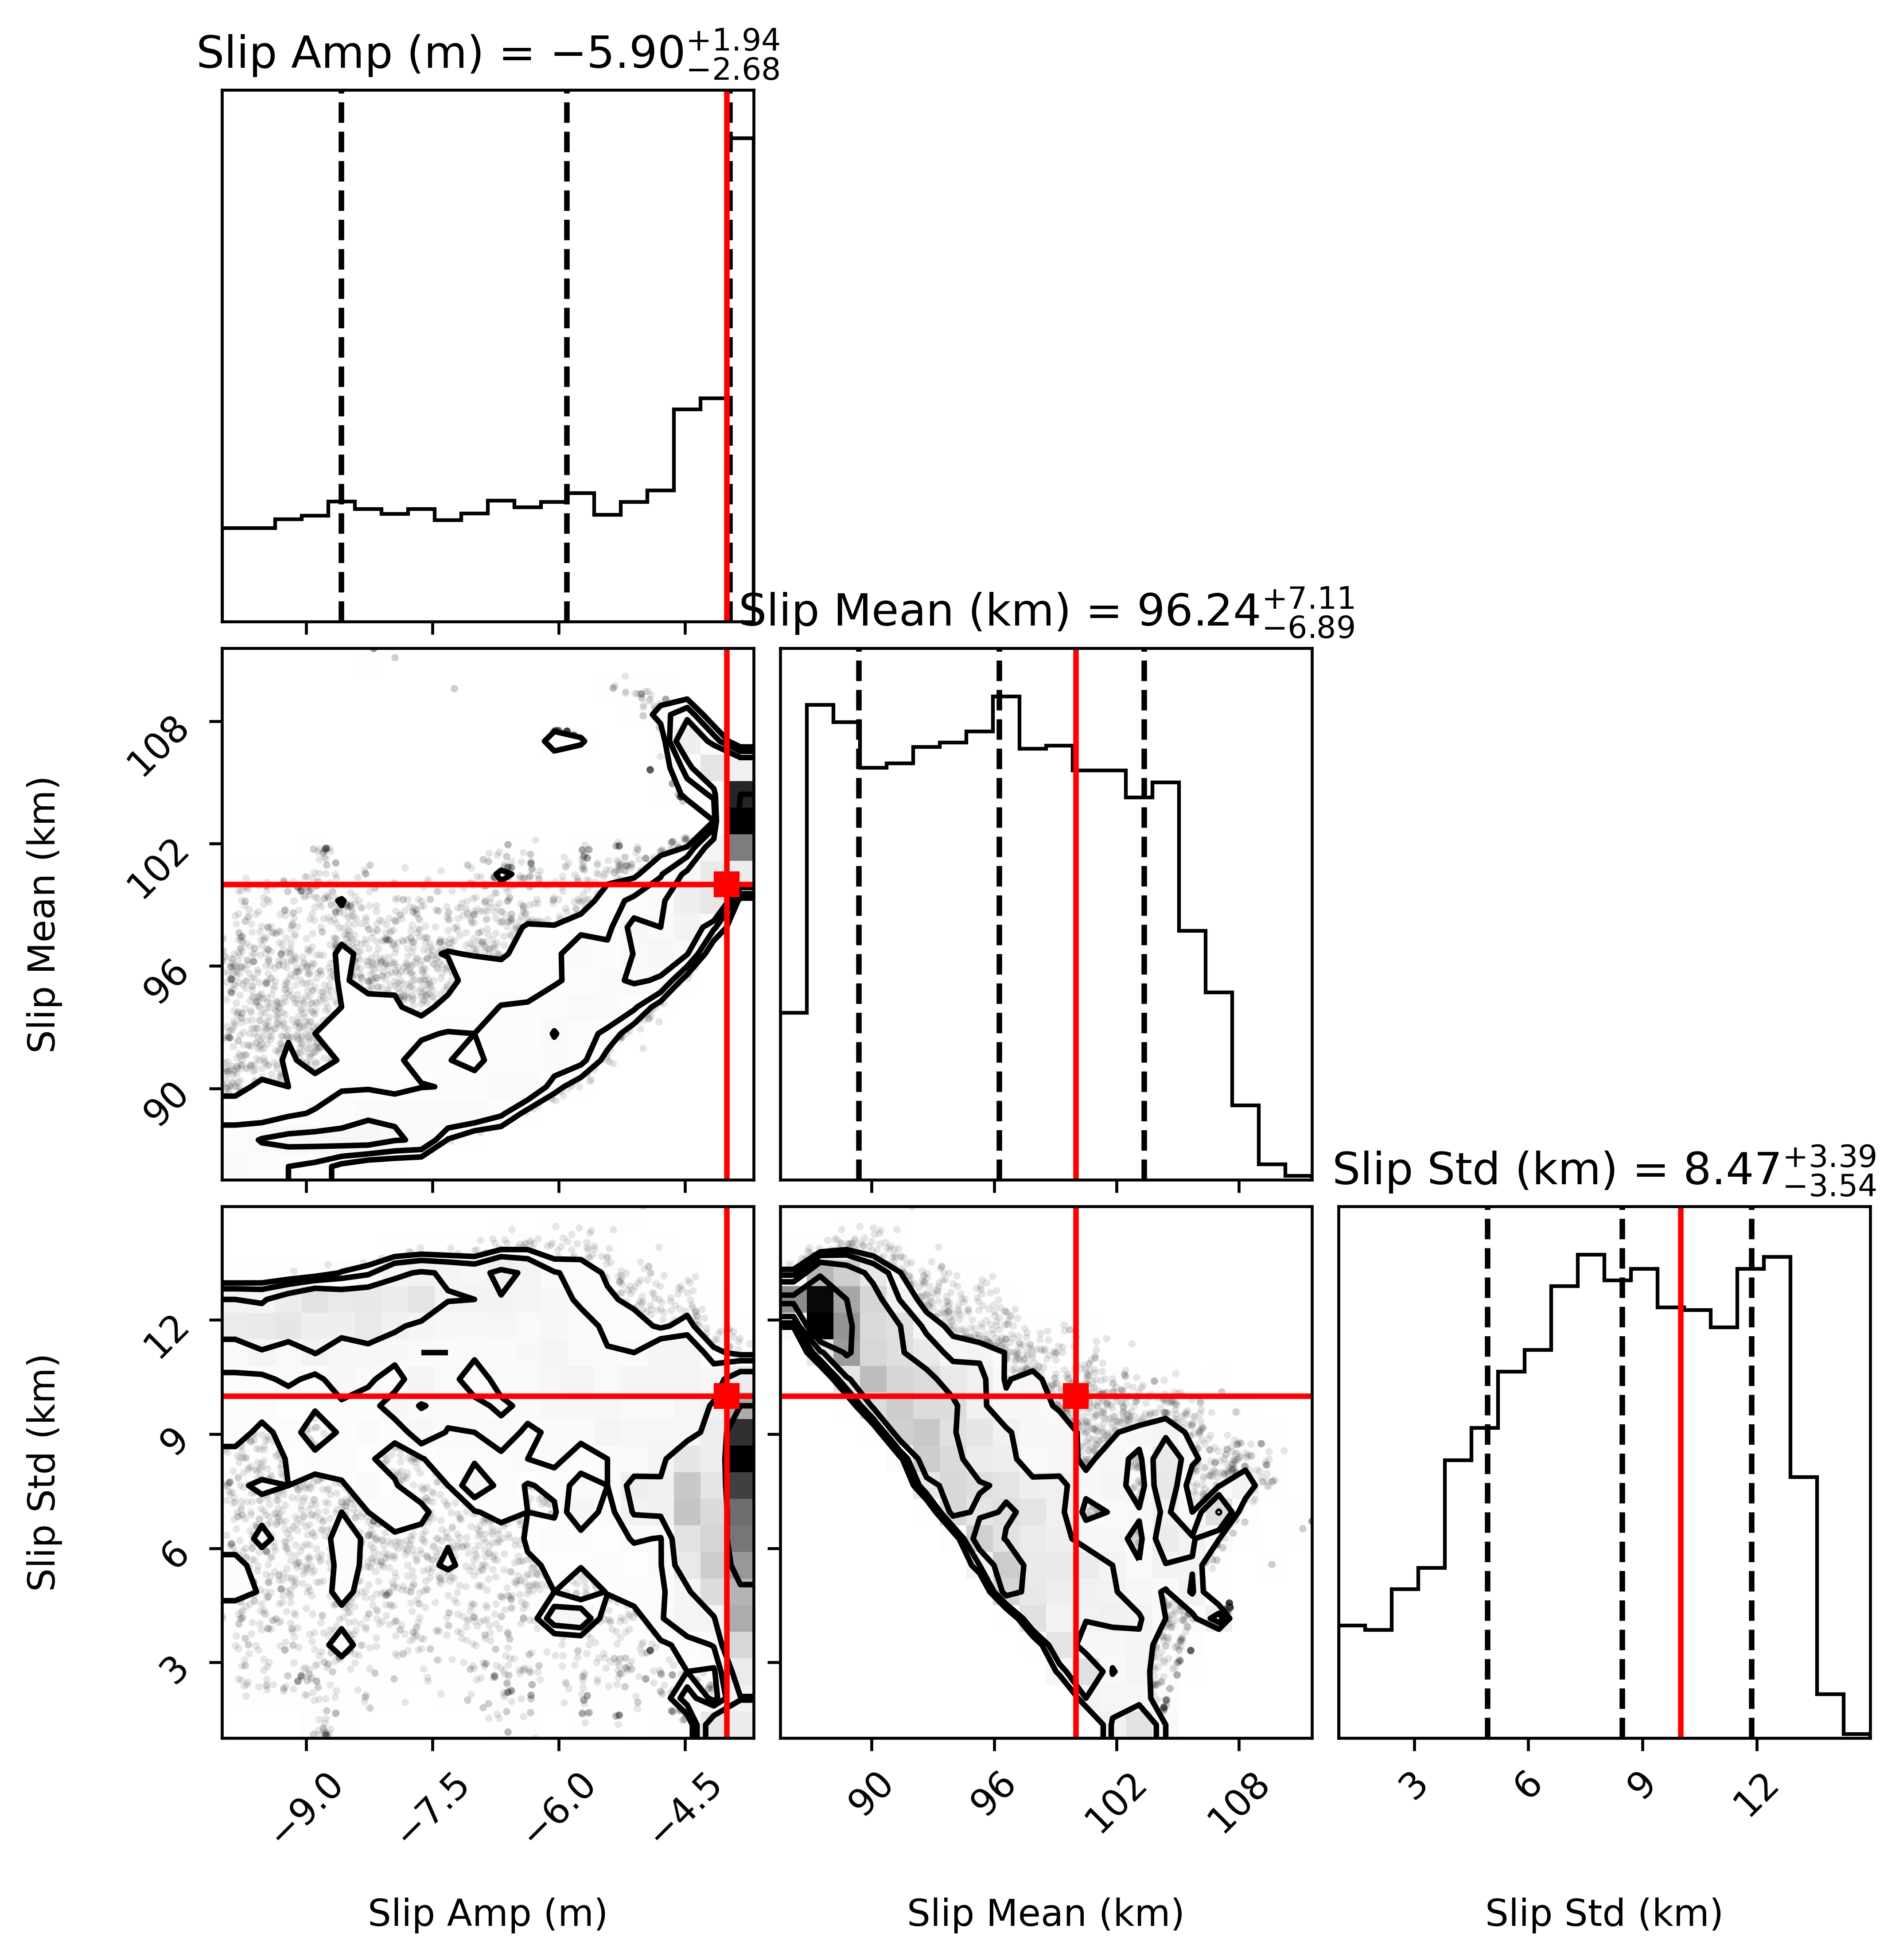

In [ ]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt

model_fault_geom = [
    {'start': (22.0, 0.0), 'end': (27.0, -4.5)},
    {'start': (27.0, -4.5), 'end': (108.0, -11.5)},
    {'start': (108.0, -11.5), 'end': (137.0, -20.5)},
    {'start': (137.0, -20.5), 'end': (183.0, -24.5)},
]

model_segment_lengths = []
model_cumulative_lengths = [0.0]
for f in model_fault_geom:
    x1, z1 = f['start']
    x2, z2 = f['end']
    length = np.hypot(x2 - x1, z2 - z1)
    model_segment_lengths.append(length)
    model_cumulative_lengths.append(model_cumulative_lengths[-1] + length)
total_model_fault_length = model_cumulative_lengths[-1]

np.random.seed(42)
data_err_m = 0.1
y_obs = uplift_total + np.random.normal(0, data_err_m, uplift_total.shape)
x_obs_mcmc = x_obs

def forward_model(params, fault_geom, segment_lengths, cumulative_lengths, x_obs_pts):
    slip_amp, slip_mean, slip_std = params
    uplift_model = np.zeros_like(x_obs_pts)
    for i, f_geom in enumerate(fault_geom):
        midpoint_length = cumulative_lengths[i] + segment_lengths[i] / 2.0
        slip = gaussian_slip(midpoint_length, slip_amp, slip_mean, slip_std)
        x1, z1 = f_geom['start']
        x2, z2 = f_geom['end']
        d_top, d_bot = -z1, -z2
        x_top, x_bot = x1, x2
        delta = np.arctan2(-(z2 - z1), x2 - x1)
        uplift_top = calculate_uplift_from_slip(x_obs_pts, slip, delta, d_top, x_top)
        uplift_bot = calculate_uplift_from_slip(x_obs_pts, -slip, delta, d_bot, x_bot)
        uplift_model += (uplift_top + uplift_bot)
    return uplift_model

def log_prior(params):
    slip_amp, slip_mean, slip_std = params
    if -10 < slip_amp < 0 and 0.0 < slip_mean < total_model_fault_length and 1.0 < slip_std < 50.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y, yerr, fault_geom, segment_lengths, cumulative_lengths):
    model_y = forward_model(params, fault_geom, segment_lengths, cumulative_lengths, x)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model_y)**2 / sigma2)

def log_probability(params, x, y, yerr, fault_geom, segment_lengths, cumulative_lengths):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr, fault_geom, segment_lengths, cumulative_lengths)

nwalkers = 64
ndim = 3
nsteps = 5000
burnin = 1500

initial_guess = np.array([-5, 50.0, 15.0])
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

mcmc_args = (x_obs_mcmc, y_obs, data_err_m, model_fault_geom, model_segment_lengths, model_cumulative_lengths)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=mcmc_args)
sampler.run_mcmc(pos, nsteps, progress=True)

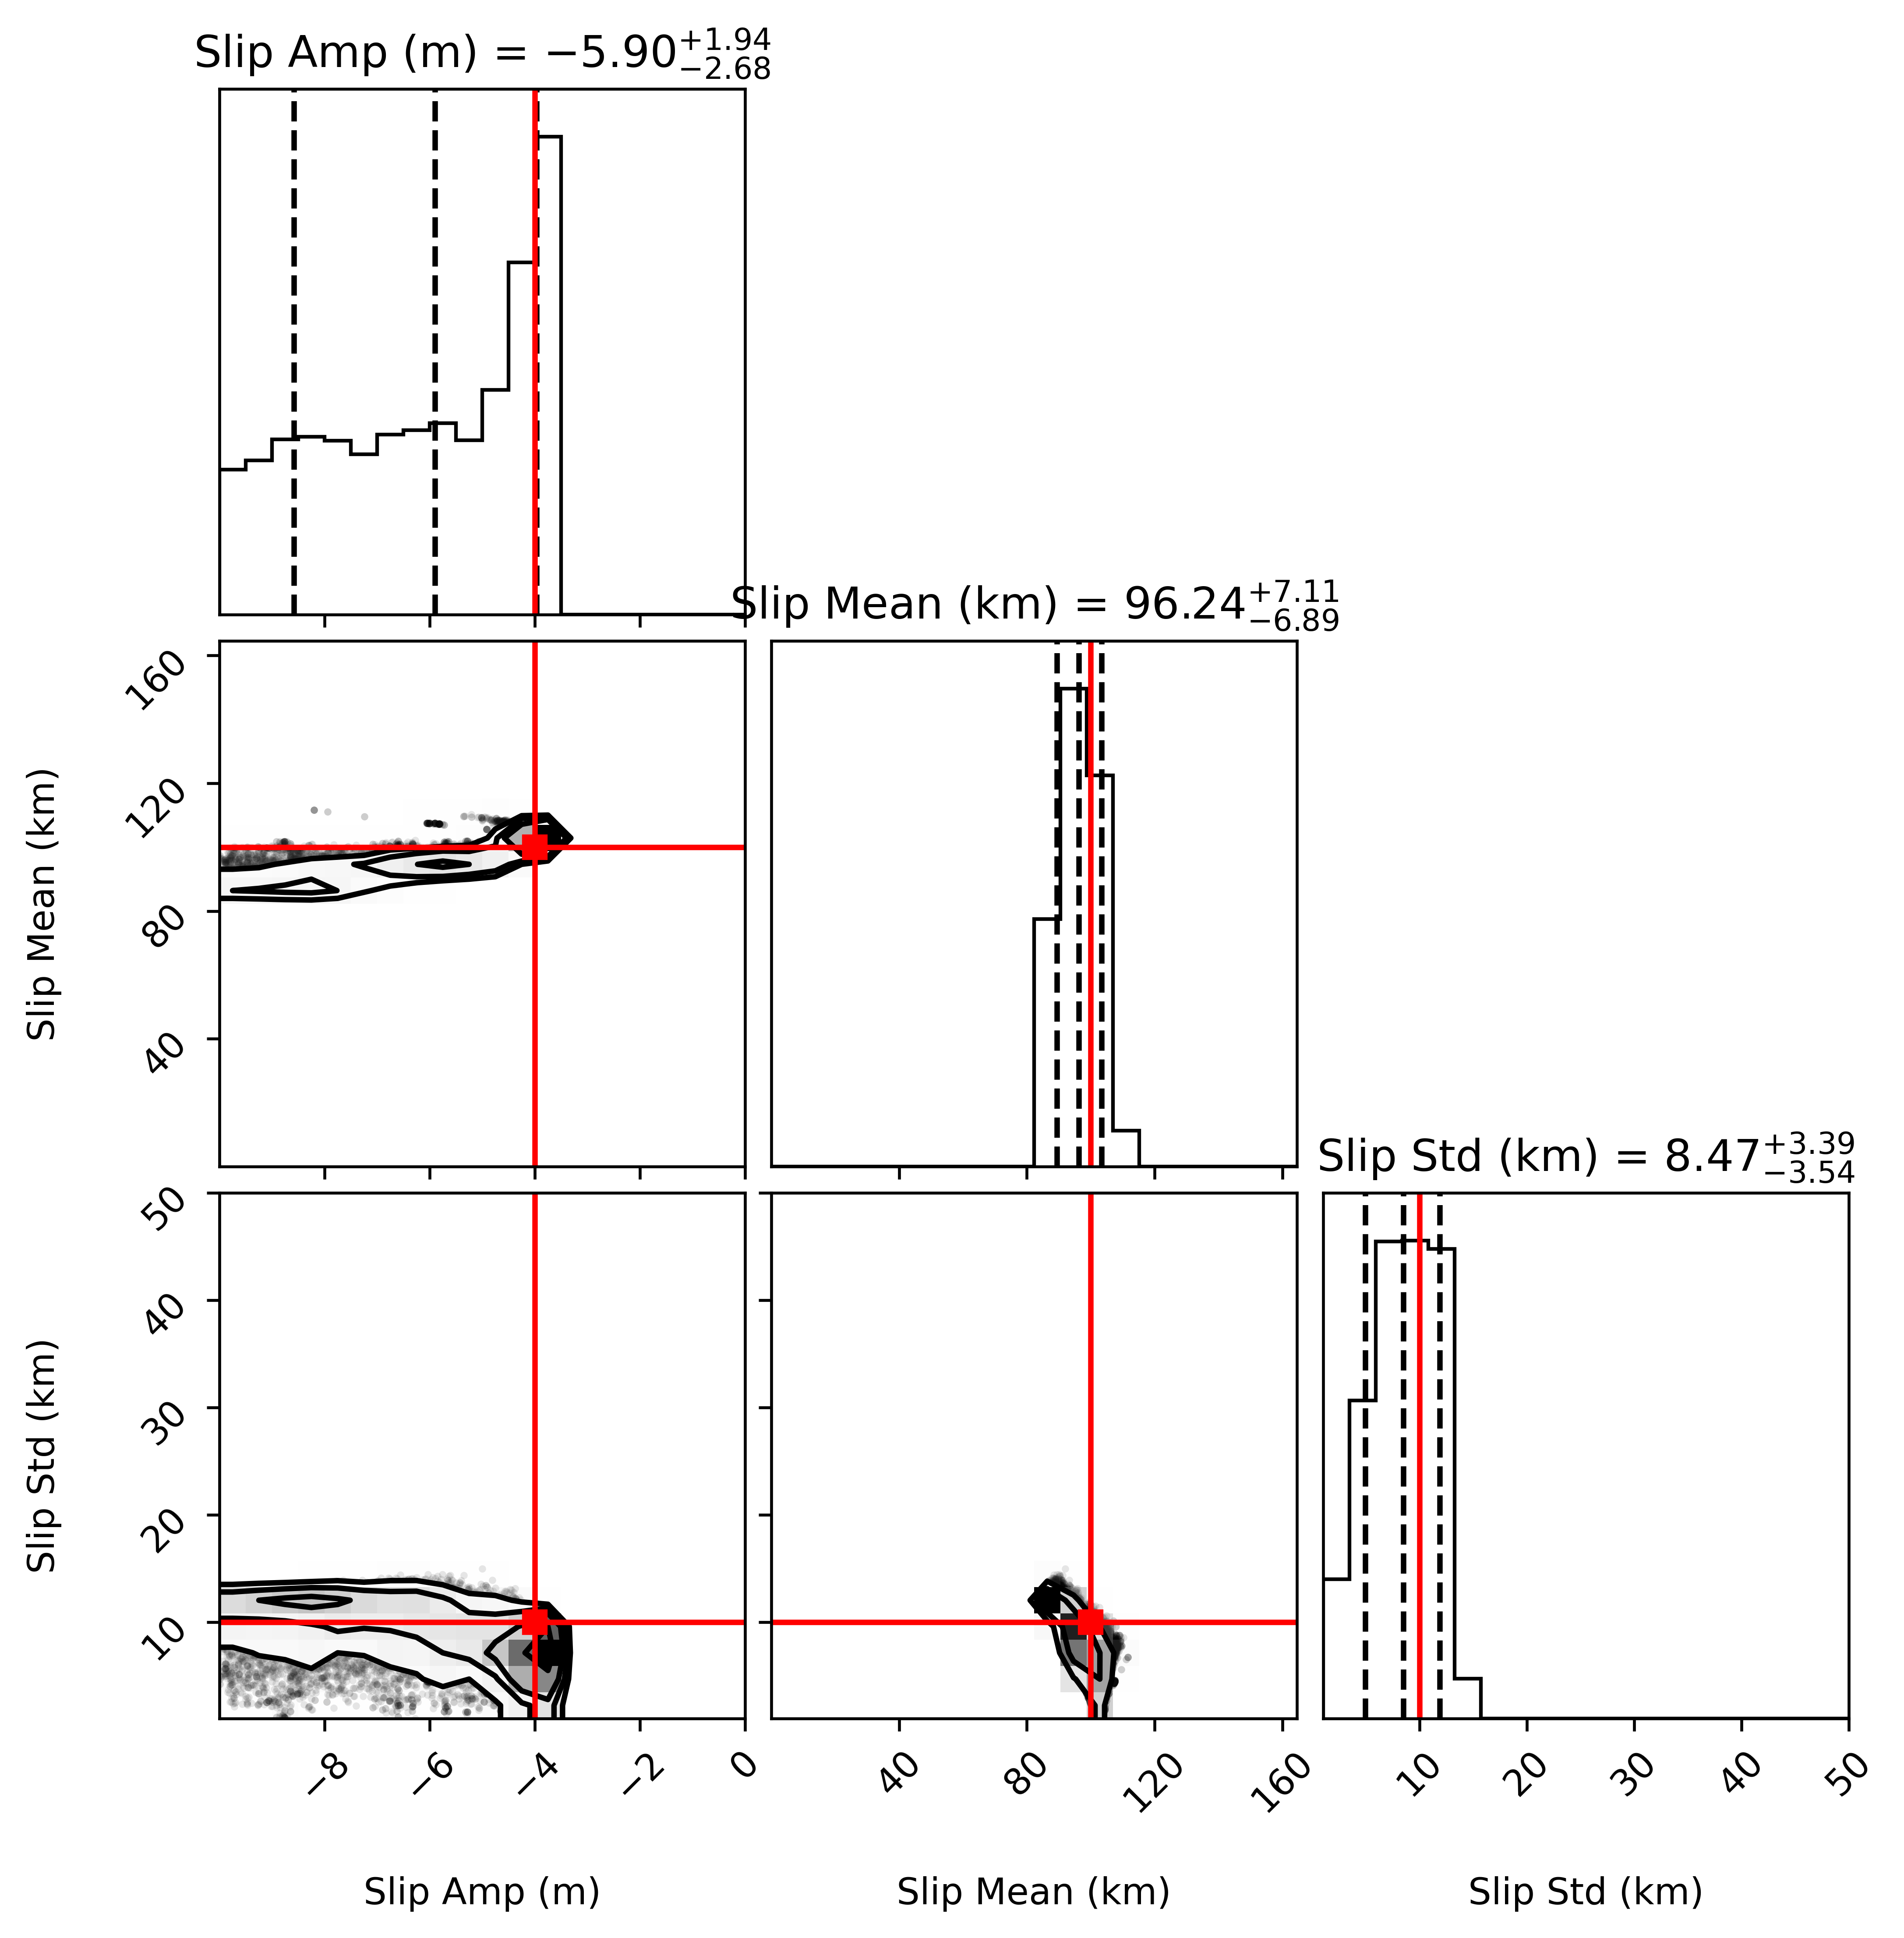

In [94]:
samples = sampler.get_chain(discard=burnin, thin=20, flat=True)

labels = ["Slip Amp (m)", "Slip Mean (km)", "Slip Std (km)"]
true_params = [SLIP_AMP_METERS, SLIP_MEAN, SLIP_STD]

prior_ranges = [(-10, 0), (0, total_model_fault_length), (1, 50)]

fig_corner = corner.corner(
    samples,
    labels=labels,
    truths=true_params,
    range=prior_ranges,  # Set the plot range here
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truth_color='red'
)

plt.show()

--- Posterior Model Parameters (50th percentile) ---
Slip Amplitude: -5.90063 m (True: -4.00000)
Slip Mean:      96.24 km (True: 100.00)
Slip Std Dev:   8.47 km (True: 10.00)


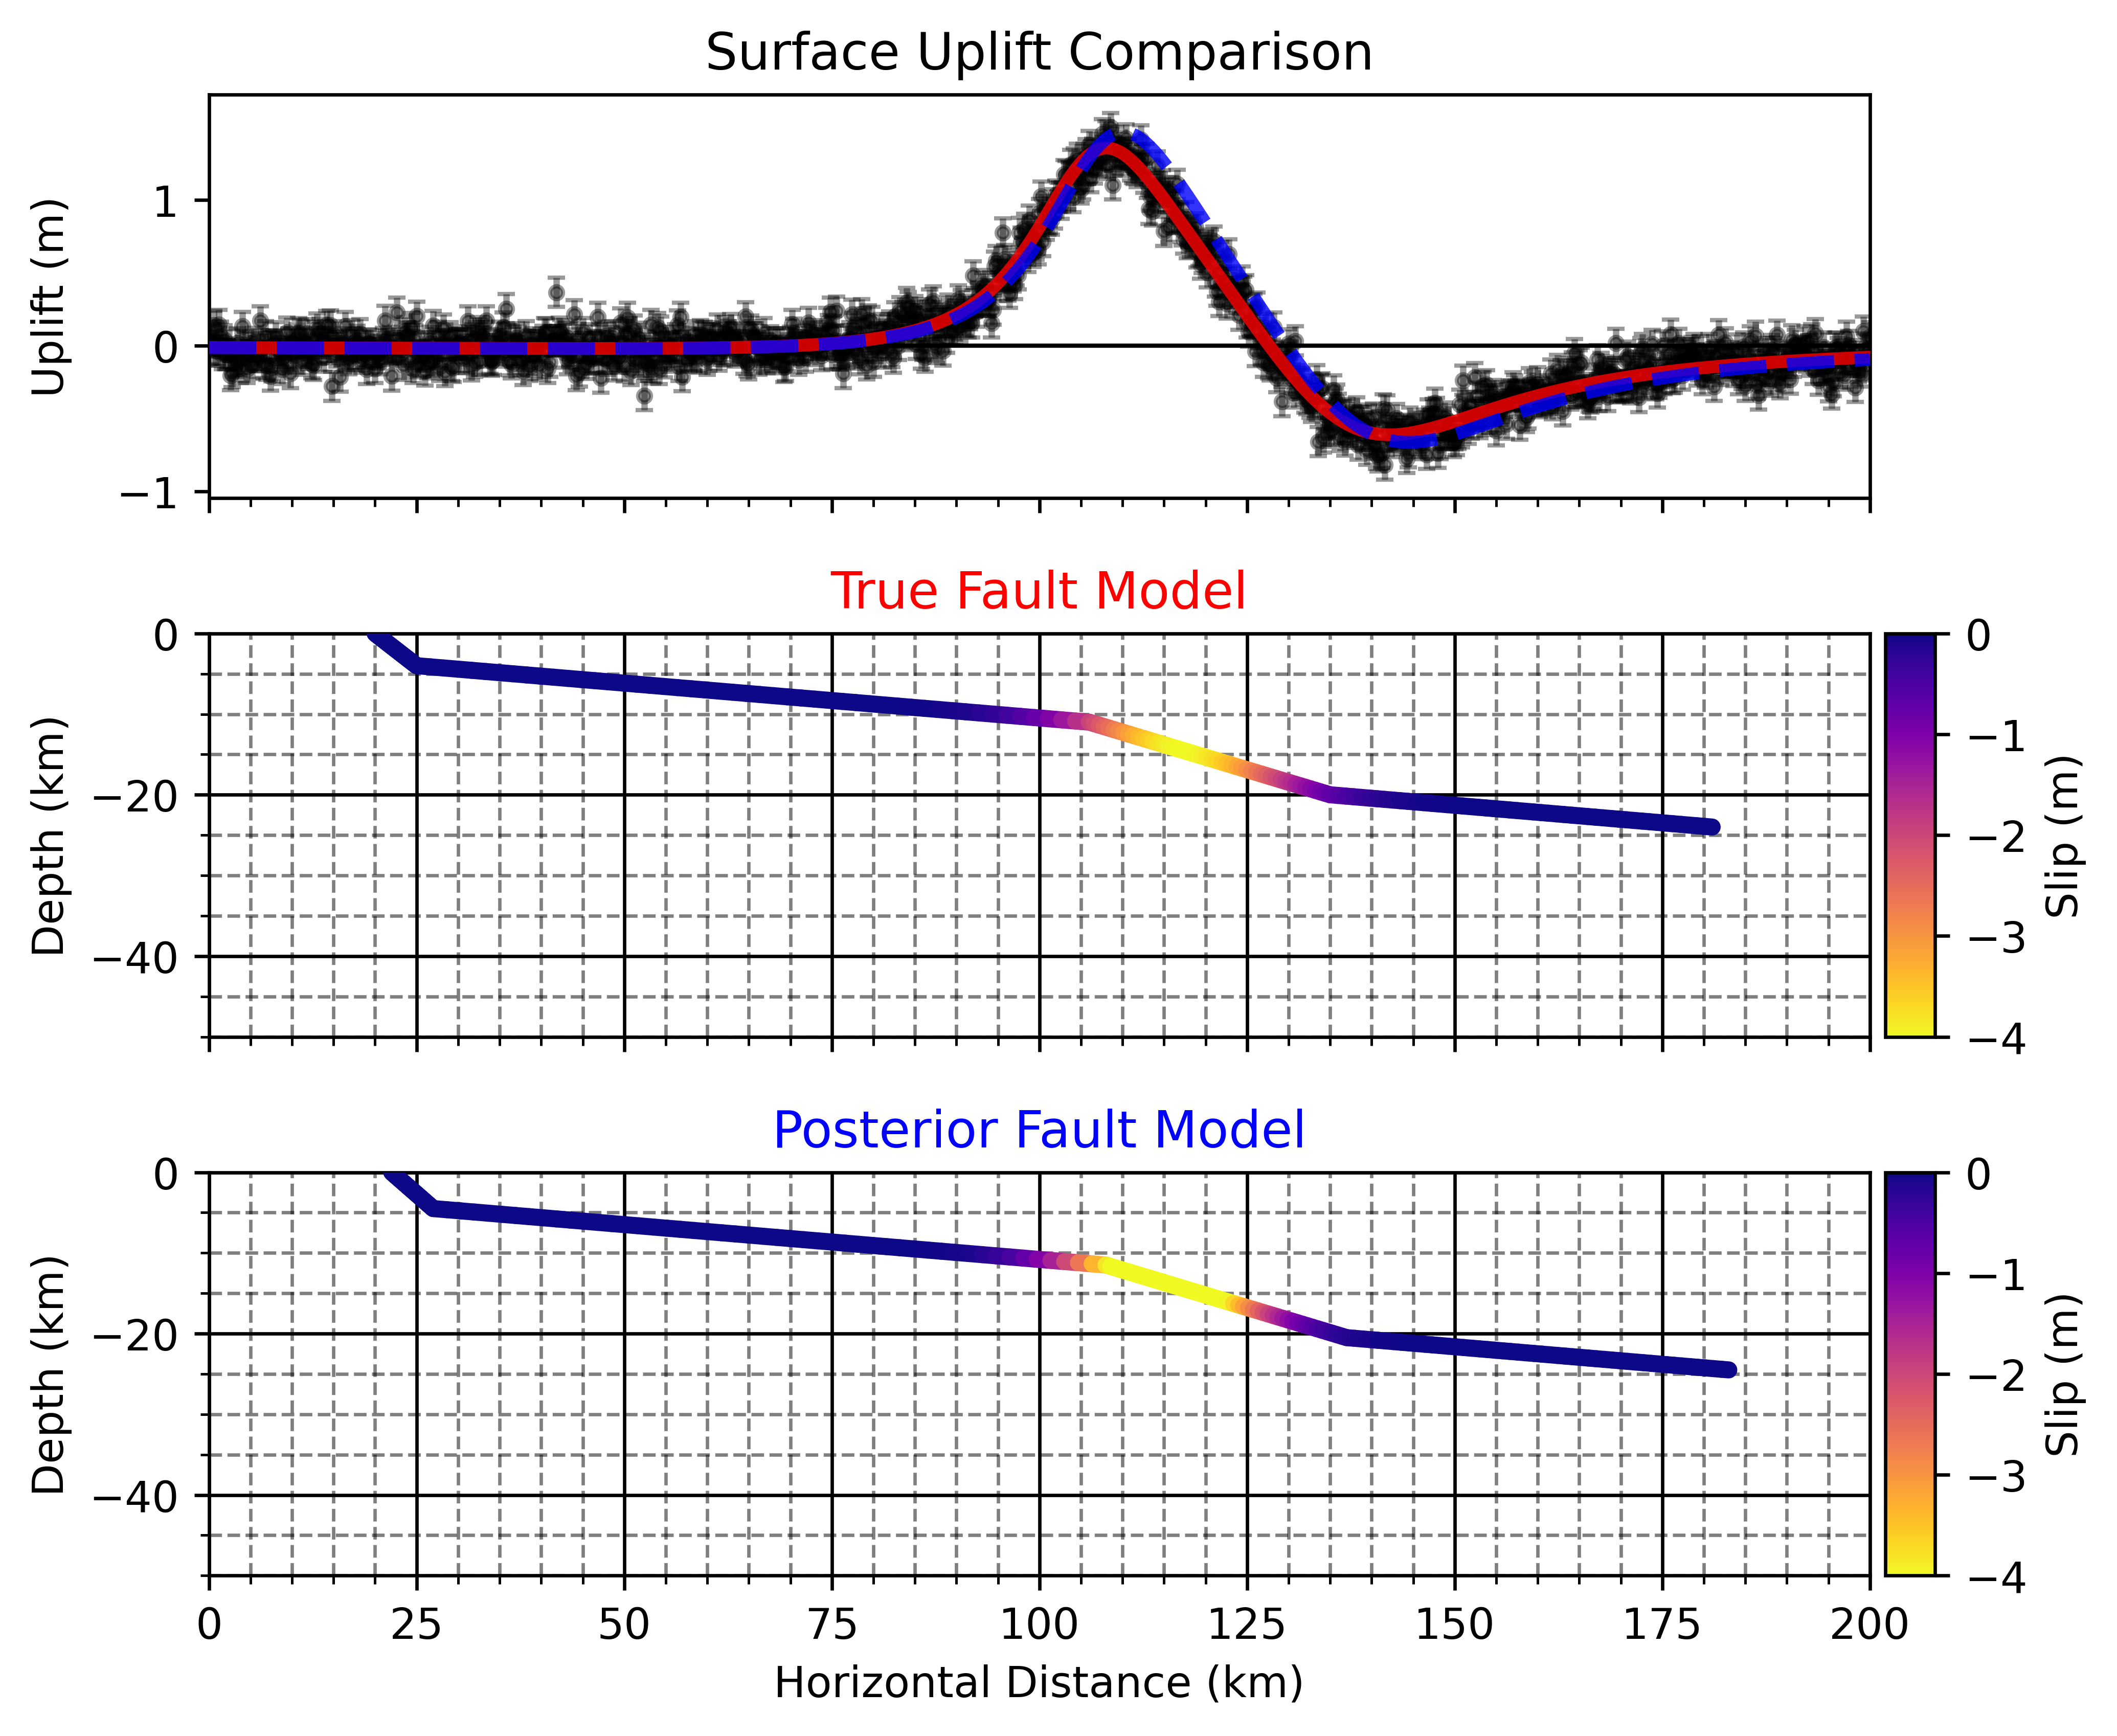

In [93]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

posterior_amp, posterior_mean, posterior_std = np.percentile(samples, 50, axis=0)

print("--- Posterior Model Parameters (50th percentile) ---")
print(f"Slip Amplitude: {posterior_amp:.5f} m (True: {SLIP_AMP_METERS:.5f})")
print(f"Slip Mean:      {posterior_mean:.2f} km (True: {SLIP_MEAN:.2f})")
print(f"Slip Std Dev:   {posterior_std:.2f} km (True: {SLIP_STD:.2f})")

posterior_params = [posterior_amp, posterior_mean, posterior_std]
uplift_posterior = forward_model(
    posterior_params,
    model_fault_geom,
    model_segment_lengths,
    model_cumulative_lengths,
    x_obs
)

fig, (ax_top, ax_mid, ax_bot) = plt.subplots(
    3, 1,
    figsize=(7, 6),
    sharex=True
)

ax_top.plot(x_obs, uplift_total, 'r-', lw=3, alpha=0.8, label="True Uplift", zorder=30)
ax_top.plot(x_obs, uplift_posterior, 'b--', lw=3, alpha=0.8, label="Posterior Uplift (Median Fit)", zorder=50)
ax_top.errorbar(x_obs_mcmc, y_obs, yerr=data_err_m, fmt='.', color='k', capsize=2, alpha=0.4, label="Synthetic Data")
ax_top.axhline(0, lw=1.0, color='black')
ax_top.set_ylabel("Uplift (m)")
ax_top.set_title("Surface Uplift Comparison")

divider_top = make_axes_locatable(ax_top)
cax_top = divider_top.append_axes("right", size="3%", pad=0.05)
cax_top.axis('off')

norm_shared = Normalize(vmin=-4, vmax=0)
cmap_shared = plt.cm.plasma_r

ax_mid.set_title("True Fault Model", color='red')
for i, f_geom in enumerate(true_faults_geom):
    x1, z1, x2, z2 = f_geom['start'][0], f_geom['start'][1], f_geom['end'][0], f_geom['end'][1]
    x_points = np.linspace(x1, x2, n_gradient_points)
    z_points = np.linspace(z1, z2, n_gradient_points)
    len_points = np.linspace(cumulative_lengths[i], cumulative_lengths[i+1], n_gradient_points)
    for j in range(n_gradient_points - 1):
        mid_len = (len_points[j] + len_points[j+1]) / 2.0
        slip_m = gaussian_slip(mid_len, SLIP_AMP_METERS, SLIP_MEAN, SLIP_STD)
        color = cmap_shared(norm_shared(slip_m))
        ax_mid.plot(x_points[j:j+2], z_points[j:j+2], color=color, lw=4, zorder=10, solid_capstyle='round')
ax_mid.set_ylabel("Depth (km)")

divider_mid = make_axes_locatable(ax_mid)
cax_mid = divider_mid.append_axes("right", size="3%", pad=0.05)
sm_true = ScalarMappable(cmap=cmap_shared, norm=norm_shared)
cbar_true = fig.colorbar(sm_true, cax=cax_mid)
cbar_true.set_label('Slip (m)')

ax_bot.set_title("Posterior Fault Model", color='blue')
for i, f_geom in enumerate(model_fault_geom):
    x1, z1, x2, z2 = f_geom['start'][0], f_geom['start'][1], f_geom['end'][0], f_geom['end'][1]
    x_points = np.linspace(x1, x2, n_gradient_points)
    z_points = np.linspace(z1, z2, n_gradient_points)
    len_points = np.linspace(model_cumulative_lengths[i], model_cumulative_lengths[i+1], n_gradient_points)
    for j in range(n_gradient_points - 1):
        mid_len = (len_points[j] + len_points[j+1]) / 2.0
        slip_m = gaussian_slip(mid_len, posterior_amp, posterior_mean, posterior_std)
        color = cmap_shared(norm_shared(slip_m))
        ax_bot.plot(x_points[j:j+2], z_points[j:j+2], color=color, lw=4, zorder=10, solid_capstyle='round')

divider_bot = make_axes_locatable(ax_bot)
cax_bot = divider_bot.append_axes("right", size="3%", pad=0.05)
sm_post = ScalarMappable(cmap=cmap_shared, norm=norm_shared)
cbar_post = fig.colorbar(sm_post, cax=cax_bot)
cbar_post.set_label('Slip (m)')

for ax in [ax_mid, ax_bot]:
    ax.set_ylabel("Depth (km)")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_bot, 0)
    ax.grid(True, which='major', linestyle='-', alpha=1,color='black')
    ax.grid(True, which='minor', linestyle='--', alpha=0.5,color='black')
    ax.minorticks_on()

ax_bot.set_xlabel("Horizontal Distance (km)")

plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_mid.get_xticklabels(), visible=False)

fig.align_ylabels()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()